<a href="https://colab.research.google.com/github/vfrantc/deweather/blob/main/train_decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Tue Jun 21 19:47:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [4]:
!git clone https://github.com/aasharma90/RetinexNet_PyTorch.git
%cd RetinexNet_PyTorch/

Cloning into 'RetinexNet_PyTorch'...
remote: Enumerating objects: 51, done.
remote: Total 51 (delta 0), reused 0 (delta 0), pack-reused 51
Unpacking objects: 100% (51/51), done.
/content/RetinexNet_PyTorch


In [5]:
!cp /content/drive/MyDrive/deweather2/BrighteningTrain.zip .
!cp /content/drive/MyDrive/deweather2/LOLdataset.zip .
!unzip BrighteningTrain.zip
!unzip LOLdataset.zip

Archive:  BrighteningTrain.zip
   creating: BrighteningTrain/
   creating: BrighteningTrain/high/
  inflating: BrighteningTrain/high/r17fe8532t.png  
  inflating: BrighteningTrain/high/r0648cff8t.png  
  inflating: BrighteningTrain/high/r1c243af7t.png  
  inflating: BrighteningTrain/high/r1800ab47t.png  
  inflating: BrighteningTrain/high/r09d5cb41t.png  
  inflating: BrighteningTrain/high/r0eedd456t.png  
  inflating: BrighteningTrain/high/r13837601t.png  
  inflating: BrighteningTrain/high/r0438eb97t.png  
  inflating: BrighteningTrain/high/r04e19833t.png  
  inflating: BrighteningTrain/high/r1e367d35t.png  
  inflating: BrighteningTrain/high/r1d1d501et.png  
  inflating: BrighteningTrain/high/r098a8a22t.png  
  inflating: BrighteningTrain/high/r0a31a2cct.png  
  inflating: BrighteningTrain/high/r17217693t.png  
  inflating: BrighteningTrain/high/r1c5ec853t.png  
  inflating: BrighteningTrain/high/r07598392t.png  
  inflating: BrighteningTrain/high/r094cf3c6t.png  
  inflating: Brigh

In [6]:
!rm -rf __MACOSX *.zip
!mv eval15 data
!mv our485 data

In [7]:
!mv BrighteningTrain/ data/syn

In [8]:
!python3 train.py --data_dir="."

Number of training data: 1485
Model restore success!
Start training for phase Decom, with start epoch 100 start iter 9200 : 
Finished training for phase Decom.
Model restore success!
Start training for phase Relight, with start epoch 100 start iter 9200 : 
Finished training for phase Relight.


# Load and use the part of the model

In [9]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [10]:
class DecomNet(nn.Module):
    def __init__(self, channel=64, kernel_size=3):
        super(DecomNet, self).__init__()
        # Shallow feature extraction
        self.net1_conv0 = nn.Conv2d(4, channel, kernel_size * 3,
                                    padding=4, padding_mode='replicate')
        # Activated layers!
        self.net1_convs = nn.Sequential(nn.Conv2d(channel, channel, kernel_size,
                                                  padding=1, padding_mode='replicate'),
                                        nn.ReLU(),
                                        nn.Conv2d(channel, channel, kernel_size,
                                                  padding=1, padding_mode='replicate'),
                                        nn.ReLU(),
                                        nn.Conv2d(channel, channel, kernel_size,
                                                  padding=1, padding_mode='replicate'),
                                        nn.ReLU(),
                                        nn.Conv2d(channel, channel, kernel_size,
                                                  padding=1, padding_mode='replicate'),
                                        nn.ReLU(),
                                        nn.Conv2d(channel, channel, kernel_size,
                                                  padding=1, padding_mode='replicate'),
                                        nn.ReLU())
        # Final recon layer
        self.net1_recon = nn.Conv2d(channel, 4, kernel_size,
                                    padding=1, padding_mode='replicate')

    def forward(self, input_im):
        input_max= torch.max(input_im, dim=1, keepdim=True)[0] # max value of R, G, B
        input_img= torch.cat((input_max, input_im), dim=1)     #
        feats0   = self.net1_conv0(input_img) # first convolution, # lear transform
        featss   = self.net1_convs(feats0)    #
        outs     = self.net1_recon(featss)
        R        = torch.sigmoid(outs[:, 0:3, :, :]) # reflectance
        L        = torch.sigmoid(outs[:, 3:4, :, :]) # light
        return R, L

In [11]:
def get_decom(trainable=True):
  net = DecomNet().cuda()
  ckpt_dict  = torch.load('ckpts/Decom/9200.tar') # , map_location=torch.device('cpu')
  net.load_state_dict(ckpt_dict)
  for p in net.parameters():
      p.requires_grad = trainable
  return net

In [12]:
net = get_decom()

In [13]:
def decom_image(image):
  test_low_img   = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
  test_low_img   = np.transpose(test_low_img, (2, 0, 1))
  input_low_test = np.expand_dims(test_low_img, axis=0)
  input_low_test = Variable(torch.FloatTensor(torch.from_numpy(input_low_test))).cuda()
  R_low, I_low   = net(input_low_test)
  R_low = np.clip(np.transpose(R_low.cpu().detach().numpy().squeeze(), (1, 2, 0)), 0, 1)
  I_low = np.clip(I_low.cpu().detach().numpy().squeeze(), 0, 1)
  return R_low, I_low

In [14]:
!cp /content/drive/MyDrive/deweather2/input.zip .

In [15]:
!unzip input.zip

Archive:  input.zip
   creating: input/
  inflating: input/get_list.py.ipynb  
  inflating: input/.DS_Store         
  inflating: __MACOSX/input/._.DS_Store  
  inflating: input/natural.txt       
   creating: input/input/
   creating: input/.ipynb_checkpoints/
  inflating: input/input/348.png     
  inflating: input/input/412.png     
  inflating: input/input/374.png     
  inflating: input/input/360.png     
  inflating: input/input/406.png     
  inflating: input/input/638.png     
  inflating: input/input/176.png     
  inflating: input/input/610.png     
  inflating: input/input/604.png     
  inflating: input/input/162.png     
  inflating: input/input/002.png     
  inflating: input/input/016.png     
  inflating: input/input/228.png     
  inflating: input/input/566.png     
  inflating: input/input/200.png     
  inflating: input/input/214.png     
  inflating: input/input/572.png     
  inflating: input/input/599.png     
  inflating: input/input/215.png     
  inflating: inp

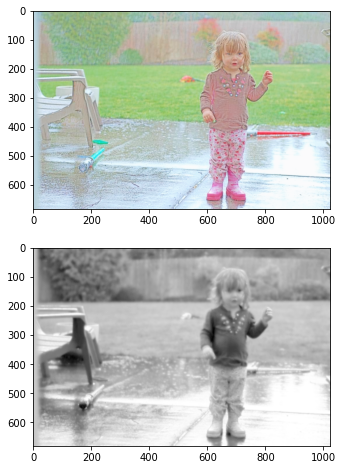

In [44]:
FNAME = 'input/input/010.png'
dehazed_image = cv2.imread(FNAME)
reflectance, illumination = decom_image(dehazed_image)

fig, axs = plt.subplots(2, figsize=(16, 8))
axs[0].imshow(reflectance)
axs[1].imshow(illumination, cmap='gray')